# Download Fashion MNIST Data

In [1]:
!mkdir -p ./data/fashion

In [2]:
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -o ./data/fashion/train-labels-idx1-ubyte.gz
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -o ./data/fashion/t10k-images-idx3-ubyte.gz
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -o ./data/fashion/t10k-labels-idx1-ubyte.gz
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -o ./data/fashion/train-images-idx3-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29515  100 29515    0     0   164k      0 --:--:-- --:--:-- --:--:--  164k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4318k  100 4318k    0     0  7902k      0 --:--:-- --:--:-- --:--:-- 7894k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5148  100  5148    0     0  36707      0 --:--:-- --:--:-- --:--:-- 36771
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.1M  100 25.1M    0     0  16.5M      0  0:00:01  0:00:01 --:--:-- 16.5M


# Import Packages

In [3]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow  as tf
from keras.layers import *
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [4]:
from sklearn.utils import shuffle

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Experiment Configuration

In [6]:
batch_size = 128
num_classes = 10
epochs = 50
w_l2 = 1e-4

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Data Loader function

In [78]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

## Load Data

In [79]:
x_train, y_train =load_mnist('./data/fashion', kind='train')
x_test, y_test = load_mnist('./data/fashion', kind='t10k')

## Normalize data

In [80]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Create Mixup Data

**1. All data use mixup data augmentation**

In [70]:
len_x_train = x_train.shape[0]

x_train_mixup = np.zeros_like(x_train)
y_train_mixup = np.zeros_like(y_train)

In [71]:
alpha = 0.1
np.random.seed(49)

#shuffled_x_train, shuffled_y_train = shuffle(x_train, y_train, random_state=49)

for i in range(len_x_train):
    lam = np.random.beta(alpha, alpha)
    rand_idx = np.random.choice(len_x_train)
    x_train_mixup[i] = (lam * x_train[i]) + (1. - lam) * (x_train[rand_idx])
    y_train_mixup[i] = (lam * y_train[i]) + (1. - lam) * (y_train[rand_idx])

In [49]:
x_train_mixup.shape

(60000, 28, 28, 1)

In [50]:
y_train_mixup[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.12200966,
        0.        ,  0.        ,  0.        ,  0.        ,  0.87799034])

**2. Use mixup with probability of 0.5**

In [53]:
len_x_train = x_train.shape[0]

x_train_mixup2 = np.zeros_like(x_train)
y_train_mixup2 = np.zeros_like(y_train)

In [54]:
alpha = 0.1
np.random.seed(49)

#shuffled_x_train, shuffled_y_train = shuffle(x_train, y_train, random_state=49)

for i in range(len_x_train):
    if np.random.choice([True, False]):
        lam = np.random.beta(alpha, alpha)
        rand_idx = np.random.choice(len_x_train)            
        x_train_mixup2[i] = (lam * x_train[i]) + (1. - lam) * (x_train[rand_idx])
        y_train_mixup2[i] = (lam * y_train[i]) + (1. - lam) * (y_train[rand_idx])       
    else:
        x_train_mixup2[i] = x_train[i]
        y_train_mixup2[i] = y_train[i]
        
    # Random horizontal flip
    #if np.random.choice([True, False]):
    #    x_train_mixup2[i] = x_train_mixup2[i][:,::-1]

# Experiment

## 1. ReLU, w/o mixup data augmentation

In [81]:
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [82]:
hist_relu=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
15s - loss: 0.4789 - acc: 0.8498 - val_loss: 0.4631 - val_acc: 0.8689
Epoch 2/50
15s - loss: 0.3520 - acc: 0.8955 - val_loss: 0.3387 - val_acc: 0.8964
Epoch 3/50
15s - loss: 0.3274 - acc: 0.9091 - val_loss: 0.3262 - val_acc: 0.9088
Epoch 4/50
15s - loss: 0.3158 - acc: 0.9164 - val_loss: 0.3418 - val_acc: 0.9085
Epoch 5/50
15s - loss: 0.3055 - acc: 0.9221 - val_loss: 0.3660 - val_acc: 0.9004
Epoch 6/50
15s - loss: 0.3038 - acc: 0.9267 - val_loss: 0.3473 - val_acc: 0.9143
Epoch 7/50
15s - loss: 0.3010 - acc: 0.9309 - val_loss: 0.3481 - val_acc: 0.9147
Epoch 8/50
15s - loss: 0.2962 - acc: 0.9352 - val_loss: 0.3465 - val_acc: 0.9185
Epoch 9/50
15s - loss: 0.2972 - acc: 0.9363 - val_loss: 0.3463 - val_acc: 0.9214
Epoch 10/50
15s - loss: 0.2574 - acc: 0.9530 - val_loss: 0.3208 - val_acc: 0.9283
Epoch 11/50
15s - loss: 0.2337 - acc: 0.9584 - val_loss: 0.3060 - val_acc: 0.9336
Epoch 12/50
15s - loss: 0.2187 - acc: 0.9621 - val_loss: 

## 2. ReLU, w/ mixup data augmentation

In [83]:
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [84]:
hist_relu_mixup=model.fit(x_train_mixup, y_train_mixup,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
16s - loss: 0.6795 - acc: 0.8292 - val_loss: 0.7779 - val_acc: 0.8211
Epoch 2/50
15s - loss: 0.5468 - acc: 0.8775 - val_loss: 0.3516 - val_acc: 0.9003
Epoch 3/50
15s - loss: 0.5117 - acc: 0.8934 - val_loss: 0.3338 - val_acc: 0.9093
Epoch 4/50
15s - loss: 0.4944 - acc: 0.9023 - val_loss: 0.3507 - val_acc: 0.9104
Epoch 5/50
15s - loss: 0.4826 - acc: 0.9081 - val_loss: 0.3639 - val_acc: 0.9083
Epoch 6/50
15s - loss: 0.4731 - acc: 0.9138 - val_loss: 0.3530 - val_acc: 0.9152
Epoch 7/50
15s - loss: 0.4689 - acc: 0.9181 - val_loss: 0.3676 - val_acc: 0.9151
Epoch 8/50
15s - loss: 0.4618 - acc: 0.9222 - val_loss: 0.3692 - val_acc: 0.9133
Epoch 9/50
15s - loss: 0.4603 - acc: 0.9241 - val_loss: 0.3732 - val_acc: 0.9174
Epoch 10/50
15s - loss: 0.4185 - acc: 0.9392 - val_loss: 0.3322 - val_acc: 0.9259
Epoch 11/50
15s - loss: 0.3935 - acc: 0.9454 - val_loss: 0.3258 - val_acc: 0.9254
Epoch 12/50
15s - loss: 0.3778 - acc: 0.9476 - val_loss: 

## 3. ReLU w/ 50% Mixup

In [85]:
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [86]:
hist_relu_mixup2=model.fit(x_train_mixup2, y_train_mixup2,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
15s - loss: 0.5761 - acc: 0.8404 - val_loss: 0.8666 - val_acc: 0.8238
Epoch 2/50
15s - loss: 0.4560 - acc: 0.8878 - val_loss: 0.3340 - val_acc: 0.9036
Epoch 3/50
15s - loss: 0.4285 - acc: 0.9001 - val_loss: 0.3307 - val_acc: 0.9086
Epoch 4/50
15s - loss: 0.4149 - acc: 0.9091 - val_loss: 0.3630 - val_acc: 0.9046
Epoch 5/50
15s - loss: 0.4047 - acc: 0.9151 - val_loss: 0.3536 - val_acc: 0.9080
Epoch 6/50
15s - loss: 0.3976 - acc: 0.9211 - val_loss: 0.3437 - val_acc: 0.9172
Epoch 7/50
15s - loss: 0.3935 - acc: 0.9252 - val_loss: 0.3472 - val_acc: 0.9157
Epoch 8/50
15s - loss: 0.3869 - acc: 0.9288 - val_loss: 0.3867 - val_acc: 0.9105
Epoch 9/50
15s - loss: 0.3871 - acc: 0.9309 - val_loss: 0.3720 - val_acc: 0.9139
Epoch 10/50
15s - loss: 0.3465 - acc: 0.9465 - val_loss: 0.3297 - val_acc: 0.9277
Epoch 11/50
15s - loss: 0.3221 - acc: 0.9517 - val_loss: 0.3231 - val_acc: 0.9281
Epoch 12/50
15s - loss: 0.3031 - acc: 0.9561 - val_loss: 

# Plot Figure

In [89]:
def plot_history(hists, attribute='val_loss', axis=(-1,41,0.85,0.94), loc='lower right'):
    ylabel = {'oss': 'loss', 'acc': 'accuracy'}
    title = {'val_loss': 'valid. loss', 'loss': 'trn. loss', 'val_acc': 'valid. accuracy', 'acc': 'trn. accuracy'}
    num_hists = len(hists)
    
    plt.figure(figsize=(6, 4))  
    plt.axis(axis)
    for i in range(num_hists):
        plt.plot(hists[i].history[attribute])
    plt.title(title[attribute])  
    plt.ylabel(ylabel[attribute[-3:]])  
    plt.xlabel('epoch')  
    plt.legend(['Default', 'Mixup', "Mixup 50%"], loc=loc)  

    plt.show()

## 1. Mixup alpha=0.2

In [30]:
hists = [hist_relu, hist_relu_mixup, hist_relu_mixup2]

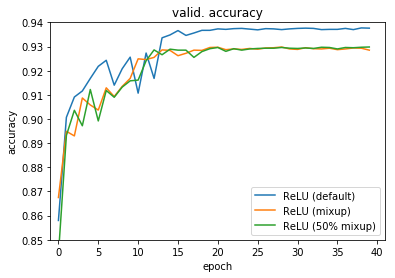

In [31]:
plot_history(hists, attribute='val_acc', loc='lower right')

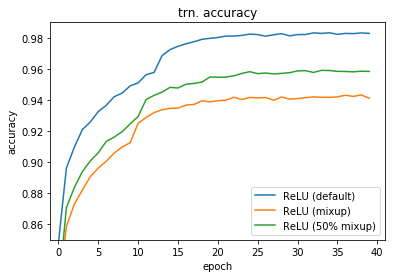

In [35]:
plot_history(hists, attribute='acc', axis=(-1,41,0.85,0.99), loc='lower right')

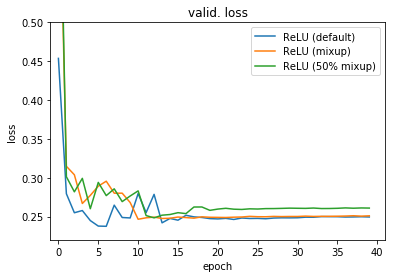

In [33]:
plot_history(hists, attribute='val_loss', axis=(-1,41,0.22,0.5), loc='upper right')

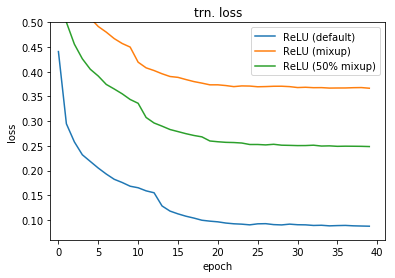

In [34]:
plot_history(hists, attribute='loss', axis=(-1,41,0.06,0.5), loc='upper right')

## 2. Mixup alpha=0.4

Note: 100% mixup is underfitting

In [55]:
hists = [hist_relu, hist_relu_mixup, hist_relu_mixup2]

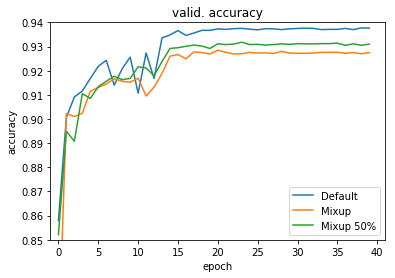

In [56]:
plot_history(hists, attribute='val_acc', loc='lower right')

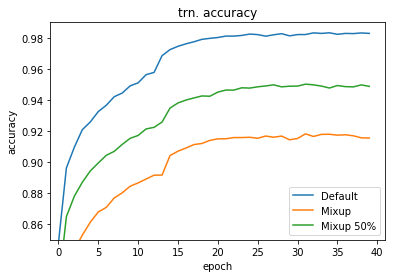

In [62]:
plot_history(hists, attribute='acc', axis=(-1,41,0.85,0.99), loc='lower right')

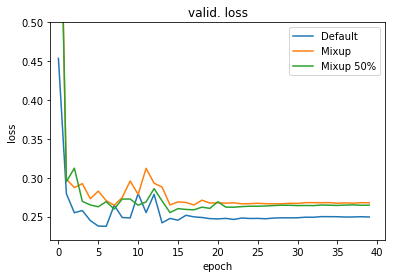

In [58]:
plot_history(hists, attribute='val_loss', axis=(-1,41,0.22,0.5), loc='upper right')

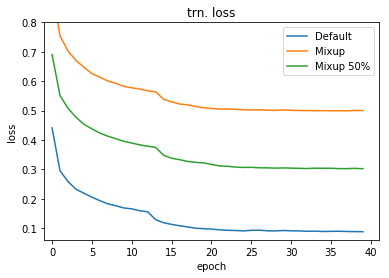

In [60]:
plot_history(hists, attribute='loss', axis=(-1,41,0.06,0.8), loc='upper right')

## 3. Mixup alpha=0.1

In [90]:
hists = [hist_relu, hist_relu_mixup, hist_relu_mixup2]

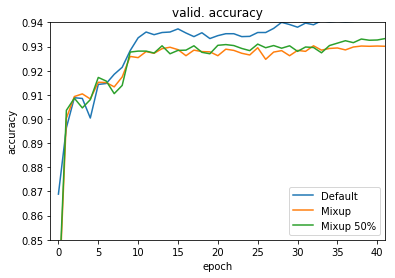

In [91]:
plot_history(hists, attribute='val_acc', loc='lower right')
#plt.legend(['Default', 'Mixup', "Mixup 50%", "MMMMMixup 50%"]) 

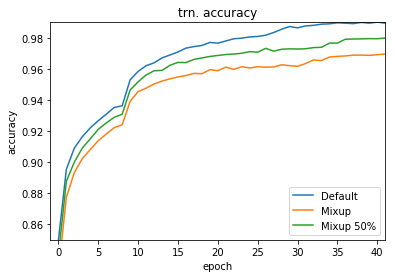

In [92]:
plot_history(hists, attribute='acc', axis=(-1,41,0.85,0.99), loc='lower right')

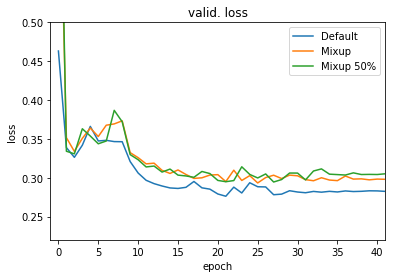

In [93]:
plot_history(hists, attribute='val_loss', axis=(-1,41,0.22,0.5), loc='upper right')

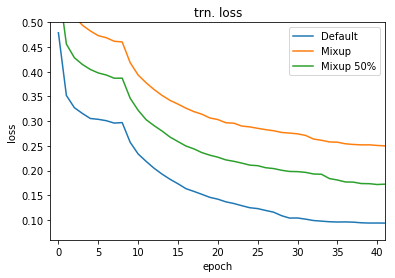

In [94]:
plot_history(hists, attribute='loss', axis=(-1,41,0.06,0.5), loc='upper right')